# Importing essential libraries 

In [6]:
import pandas as pd

# Reading the sample data

In [7]:
trans_data = pd.read_csv('Data_Files\\test_data_2.csv')


# Detecting Circular Transactions

In [8]:

# Initially all the transactions are suspicious
suspect_trans = trans_data

# Variable to keep track of change in number of suspicious transactions
change = 1
flag = 1    #Keeps track of number of iterations

# Empty variable to store circular transaction
circular_trans = []

# Iterate till the number of suspicious and circular transactions are same
while not change == 0:
    circular_trans = []
    # Print iterations and number of suspicious transaction at every iteration
    print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
    print(suspect_trans)
    # Checking whether the buyers are also the sellers
    is_seller = suspect_trans['SellerID'].isin(suspect_trans['BuyerID'].unique())
    circular_trans.extend(suspect_trans[is_seller]['TransactionID'])
    change = len(suspect_trans) - len(circular_trans)
    # Now all the circular transactions are suspicious
    suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
    suspect_trans.reset_index(drop=True, inplace=True)
    flag += 1
    
# Testing in inverse manner
change = 1
while not change == 0:
    circular_trans = []
    print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
    print(suspect_trans)
    is_buyer = suspect_trans['BuyerID'].isin(suspect_trans['SellerID'].unique())
    circular_trans.extend(suspect_trans[is_buyer]['TransactionID'])
    change = len(suspect_trans) - len(circular_trans)
    suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
    suspect_trans.reset_index(drop=True, inplace=True)
    flag += 1

# Now we have the list of transactions that can make the loop
circular_trans = suspect_trans


1
Iteration :  1 , No. of suspicious transactions :  14
   TransactionID  SellerID  BuyerID  Amount(INR)        Date
0          txn_6         8        3         60.0  21-05-2012
1          txn_5         7        7         50.0  17-09-2012
2          txn_4         5       10         40.0  12-10-2012
3          txn_3         1        4         30.0  28-05-2013
4          txn_2         2        3         20.0  15-08-2013
5          txn_7         3        2         70.0  15-08-2013
6          txn_8         1        5         80.0  16-11-2013
7          txn_1         5        1         10.0  08-08-2014
8          txn_9         6        7         90.0  31-10-2014
9         txn_11        11       12          NaN         NaN
10        txn_12        12       13          NaN         NaN
11        txn_13        13       14          NaN         NaN
12        txn_14        14       15          NaN         NaN
13        txn_15        11       11          NaN         NaN

1
Iteration :  2 , No. of s

# A look at the circular transactions

In [9]:
circular_trans

,TransactionID,SellerID,BuyerID,Amount(INR),Date
0,txn_5,7,7,50.0,17-09-2012
1,txn_2,2,3,20.0,15-08-2013
2,txn_7,3,2,70.0,15-08-2013
3,txn_8,1,5,80.0,16-11-2013
4,txn_1,5,1,10.0,08-08-2014
5,txn_15,11,11,NaN,NaN


# Lets plot and see in the directed graphs

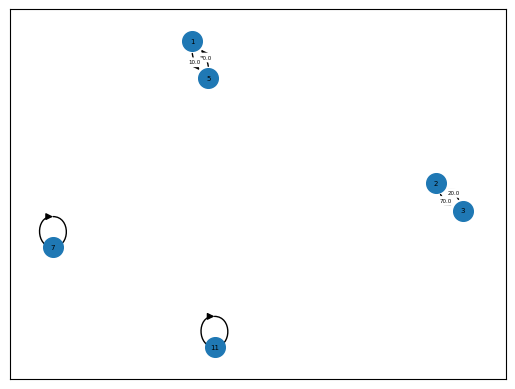

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate_multidirected_graph_image(trades_df):
    # Create a multidigraph using NetworkX
    graph = nx.DiGraph()
    for i, row in trades_df.iterrows():
        buyer, seller, amount, time = row['BuyerID'], row['SellerID'], row['Amount(INR)'], row['Date']
        if(graph.has_edge(buyer,seller)):
            graph[buyer][seller]['amount']=amount+graph[buyer][seller]['amount']
            continue
        graph.add_edge(buyer, seller, amount=amount)

    # Plot the graph
    #nodes
    G=graph
    pos=nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=200)
    nx.draw_networkx_labels(G, pos, ax=ax,font_size=5)
    #edges
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    arc_rad = 0.3
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
    #adding labels
    import my_networkx as my_nx
    edge_weights = nx.get_edge_attributes(G,'amount')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=4)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False, font_size=6)
    # fig.savefig("Graph_Visualization.png", bbox_inches='tight',pad_inches=0)
    plt.show()


# Load the trades data into a pandas DataFrame
trades_df = circular_trans

# Call the generate_multidirected_graph_image function
generate_multidirected_graph_image(trades_df)
